In [1]:
import pyccl as ccl
import numpy as np
import matplotlib.pyplot as plt

In [2]:
ls ../../

cmass_cat/               dmass_y3/                        randoms_4x_v2.fits
cmass_investigate.ipynb  fitting.py                       randoms_full_v2.fits
dmass_2024.fits          footprint.py                     random_spt_chron.fits
dmass_2024_v2.fits       make_ngal_maps.py                randoms_v2.fits
dmass_cardinal/          MASK_Y3LSSBAOSOF_22_3_v2p2.fits  skewness_fitting/
dmass_cat_public/        measure_dmass_skewness.ipynb     Untitled1.ipynb
DMASS-git-repo/          __pycache__/                     Untitled.ipynb
dmass_y1/                randoms_4x.fits


In [149]:
# compute effective redshift 
def compute_effz(z, nz):
    effz = np.sum(z * nz)/np.sum(nz)
    print ('eff_z={:0.3f}'.format(effz))
    return effz
    
def compute_b_evolution(cosmo, z, z_eff, b_eff):
    D = ccl.growth_factor(cosmo, 1/(1+z))  # comoving distance to z=1 in Mpc
    D_eff = ccl.growth_factor(cosmo, 1/(1+z_eff))  # comoving distance to z=1 in Mpc
    print (D_eff)
    return (b_eff * D_eff / D)



In [327]:
# Create new Cosmology object with a given set of parameters. This keeps track
# of previously-computed cosmological functions
#cosmo = ccl.Cosmology(
#    Omega_c=0.27, Omega_b=0.045, h=0.67, sigma8=0.8, n_s=0.96,
#    transfer_function='bbks')
cosmo = ccl.CosmologyVanillaLCDM()
# Define a simple binned galaxy number density curve as a function of redshift
#z_n = np.linspace(0., 1., 500)
#n = np.ones(z_n.shape)
# dmass nz distribution 
z_dmass, nz_dmass, _ = np.genfromtxt('../../dmass_y3/n_clustering_z_william.dat', unpack=True)
z_dmass_eff = compute_effz(z_dmass, nz_dmass)

# growth factor 
D_dmass = ccl.growth_factor(cosmo, 1/(1+z_dmass))  # comoving distance to z=1 in Mpc
#b_dmass = np.ones_like(z_dmass) * 2
b_dmass = compute_b_evolution(cosmo, z_dmass, z_dmass_eff, 2.0)

# height increased 
nz_dmass2 = nz_dmass *1.15

# low-z cut 

nz_dmass3 = nz_dmass.copy()
nz_dmass3[:15] = nz_dmass[:15] * 0.5


# low-z cut and high-z cut
#nz_dmass5 = nz_dmass.copy()
#nz_dmass5[:12] = nz_dmass[:12] * 0.3
#nz_dmass5[30:] = nz_dmass[:30] * 0.3

#z = np.linspace(0, 1, 256)
#nz = np.exp(-0.5*((z-0.5)/0.1)**2)

# cmass nz distribution 
zl, nz_cmass = np.genfromtxt('full_cmass_nz.txt', unpack=True)
dz = zl[1] - zl[0] 
z_cmass = zl + dz
z_cmass_eff = compute_effz(z_cmass, nz_cmass)
#b_cmass = np.ones_like(z_cmass) * 2
b_cmass = compute_b_evolution(cosmo, z_cmass, z_cmass_eff, 2.0)


# cmass2 nz distribution 
#z_cmass_shifted = z_cmass + 0.05
#b_cmass_shifted = np.ones_like(z_cmass_shifted) * 2

#b1 = np.ones_like(z) * 2
#A_IA = 0.6*np.ones_like(z)

tracers = {}
# Galaxy clustering
tracers['c'] = ccl.NumberCountsTracer(cosmo, has_rsd=False, dndz=(z_cmass, nz_cmass), bias=(z_cmass, b_cmass))
#tracers['c_evol'] = ccl.NumberCountsTracer(cosmo, has_rsd=False, dndz=(z_cmass, nz_cmass), bias=(z_cmass, b_cmass_evol))
#tracers['c2'] = ccl.NumberCountsTracer(cosmo, has_rsd=False, dndz=(z_cmass_shifted, nz_cmass), bias=(z_cmass_shifted, b_cmass_shifted))
tracers['d'] = ccl.NumberCountsTracer(cosmo, has_rsd=False, dndz=(z_dmass, nz_dmass), bias=(z_dmass, b_dmass))
#tracers['d_evol'] = ccl.NumberCountsTracer(cosmo, has_rsd=False, dndz=(z_dmass, nz_dmass), bias=(z_dmass, b_dmass_evol))

#tracers['d2'] = ccl.NumberCountsTracer(cosmo, has_rsd=False, dndz=(z_dmass, nz_dmass2), bias=(z_dmass, b_dmass))

# low-z cut
tracers['d3'] = ccl.NumberCountsTracer(cosmo, has_rsd=False, dndz=(z_dmass, nz_dmass3), bias=(z_dmass, b_dmass))

# gal bias adjusted 
tracers['d4'] = ccl.NumberCountsTracer(cosmo, has_rsd=False, dndz=(z_dmass, nz_dmass), bias=(z_dmass, b_dmass * 1.1))
# low-z cut + gal bias adjusted
tracers['d5'] = ccl.NumberCountsTracer(cosmo, has_rsd=False, dndz=(z_dmass, nz_dmass3), bias=(z_dmass, b_dmass * 1.05))





eff_z=0.555
0.7522018243311691
eff_z=0.550
0.7541966896694744


Text(0.5, 1.0, 'galaxy bias evolution, $b_{\\rm eff} = 2.0$')

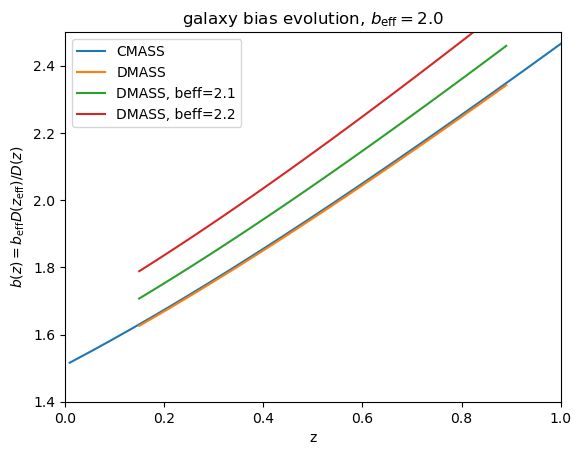

In [328]:
fig, ax = plt.subplots()
ax.plot(z_cmass, b_cmass, label='CMASS')
ax.plot(z_dmass, b_dmass, label='DMASS')
ax.plot(z_dmass, b_dmass*1.05, label='DMASS, beff=2.1')
ax.plot(z_dmass, b_dmass*1.1, label='DMASS, beff=2.2')
ax.set_xlabel('z')
ax.set_ylabel('$b(z) = b_{\\rm eff} D(z_{\\rm eff})/D(z)$')
ax.set_xlim(0, 1.0)
ax.set_ylim(1.4, 2.5)
ax.legend()
#ax.plot(z_cmass, b_cmass_evol)
ax.set_title('galaxy bias evolution, $b_{\\rm eff} = 2.0$')

In [329]:


compute_effz(z_cmass, nz_cmass)
compute_effz(z_dmass, nz_dmass)
#compute_effz(z_dmass, nz_dmass2)
compute_effz(z_dmass, nz_dmass3)
#compute_effz(z_dmass, nz_dmass5)

eff_z=0.550
eff_z=0.555
eff_z=0.563


0.5633984292082362

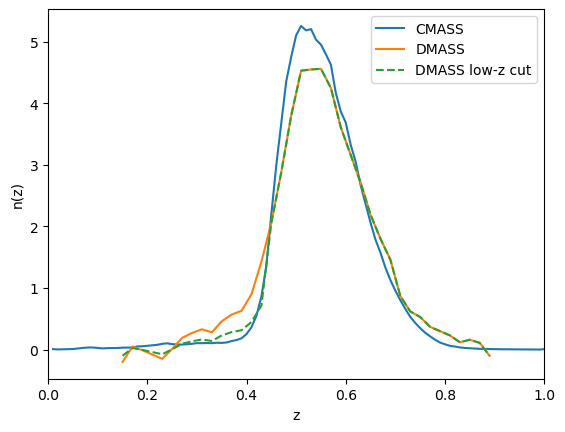

In [330]:
fig, ax = plt.subplots()

ax.plot(z_cmass, nz_cmass, label='CMASS')
#ax.plot(z_cmass_shifted, nz_cmass, label='shifted CMASS')
ax.plot(z_dmass, nz_dmass, label='DMASS')
#ax.plot(z_dmass, nz_dmass2, label='DMASS height increased')
ax.plot(z_dmass, nz_dmass3, label='DMASS low-z cut', ls='--')

#ax.plot(z_dmass, nz_dmass5, label='DMASS low/high-z cut', ls='--')
ax.set_xlim(0, 1.0)
ax.set_xlabel('z')
ax.set_ylabel( 'n(z)')
ax.legend()

In [331]:
lk_arr = np.log(np.geomspace(1E-4, 100, 256))
a_arr = 1./(1+np.linspace(0, 6., 40)[::-1])

In [332]:
m200def = ccl.halos.MassDef200m
hmf = ccl.halos.MassFuncTinker08(mass_def=m200def)
hbf = ccl.halos.HaloBiasTinker10(mass_def=m200def)
conc = ccl.halos.ConcentrationDuffy08(mass_def=m200def)

hmc = ccl.halos.HMCalculator(mass_function=hmf, halo_bias=hbf, mass_def=m200def)

In [333]:
profs = {}

# Galaxy clustering
profs['c'] = ccl.halos.HaloProfileHOD(mass_def=m200def, concentration=conc)
#profs['c_evol'] = ccl.halos.HaloProfileHOD(mass_def=m200def, concentration=conc)

profs['d'] = ccl.halos.HaloProfileHOD(mass_def=m200def, concentration=conc)
#profs['d_evol'] = ccl.halos.HaloProfileHOD(mass_def=m200def, concentration=conc)

#profs['d2'] = ccl.halos.HaloProfileHOD(mass_def=m200def, concentration=conc)
profs['d3'] = ccl.halos.HaloProfileHOD(mass_def=m200def, concentration=conc)
profs['d4'] = ccl.halos.HaloProfileHOD(mass_def=m200def, concentration=conc)
profs['d5'] = ccl.halos.HaloProfileHOD(mass_def=m200def, concentration=conc)

# Cosmic shear
#profs['s'] = ccl.halos.HaloProfileNFW(mass_def=m200def, concentration=conc)

In [334]:
tracer_list = list(profs.keys())
profs2pt = {f'{t1}-{t2}': ccl.halos.Profile2pt() for t1 in tracer_list for t2 in tracer_list}
#profs2pt['g-g'] = ccl.halos.Profile2ptHOD()
#profs2pt['c-c'] = ccl.halos.Profile2ptCIB()

In [335]:
pks = {f'{t1}-{t2}': ccl.halos.halomod_Pk2D(cosmo, hmc,
                                            profs[t1],
                                            prof_2pt=profs2pt[f'{t1}-{t2}'],
                                            prof2=profs[t2],
                                            a_arr=a_arr,
                                            lk_arr=lk_arr)
       for t1 in tracer_list for t2 in tracer_list}

In [336]:
pks.keys()

dict_keys(['c-c', 'c-d', 'c-d3', 'c-d4', 'c-d5', 'd-c', 'd-d', 'd-d3', 'd-d4', 'd-d5', 'd3-c', 'd3-d', 'd3-d3', 'd3-d4', 'd3-d5', 'd4-c', 'd4-d', 'd4-d3', 'd4-d4', 'd4-d5', 'd5-c', 'd5-d', 'd5-d3', 'd5-d4', 'd5-d5'])

In [337]:
ells = np.unique(np.geomspace(2, 2000, 128).astype(int)).astype(float)
c_ells = {f'{t1}-{t2}': ccl.angular_cl(cosmo, tracers[t1], tracers[t2], ells, p_of_k_a=pks[f'{t1}-{t2}'])
          for t1 in tracer_list for t2 in tracer_list}

In [338]:
theta = np.logspace(np.log10(2.5), np.log10(250), 21)
theta = (theta[:-1] + theta[1:])/2
theta_degree = theta/60.0
#theta_radian = theta_degree * 0.0174533
wtheta_cmass = cosmo.correlation(ell=ells, C_ell=c_ells['c-c'], theta=theta_degree, type='NN')
#wtheta_cmass_evol = cosmo.correlation(ell=ells, C_ell=c_ells['c_evol-c_evol'], theta=theta_degree, type='NN')

wtheta_dmass = cosmo.correlation(ell=ells, C_ell=c_ells['d-d'], theta=theta_degree, type='NN')
#wtheta_dmass_evol = cosmo.correlation(ell=ells, C_ell=c_ells['d_evol-d_evol'], theta=theta_degree, type='NN')

#wtheta_dmass2 = cosmo.correlation(ell=ells, C_ell=c_ells['d2-d2'], theta=theta_degree, type='NN')
wtheta_dmass3 = cosmo.correlation(ell=ells, C_ell=c_ells['d3-d3'], theta=theta_degree, type='NN')
wtheta_dmass4 = cosmo.correlation(ell=ells, C_ell=c_ells['d4-d4'], theta=theta_degree, type='NN')
wtheta_dmass5 = cosmo.correlation(ell=ells, C_ell=c_ells['d5-d5'], theta=theta_degree, type='NN')

In [339]:
cov_dat = np.genfromtxt('../../dmass_y3/test_dmass_v3_llll_cov_Ntheta20_Ntomo0_1')
cov = np.zeros((20,20))
w, h = 20, 20
for i in range(20*h):
    x = int(cov_dat[i][0])
    y = int(cov_dat[i][1])
    cov[x][y] = cov_dat[i][8]   

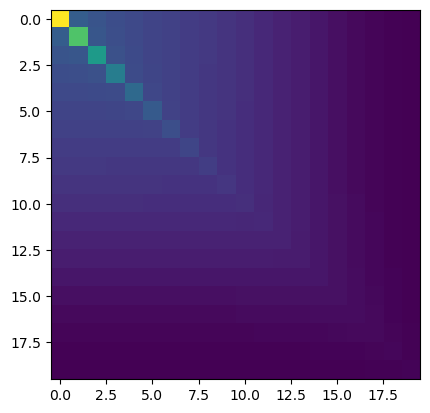

In [340]:
fig, ax = plt.subplots()
ax.imshow(cov)

In [341]:
err = np.sqrt(cov.diagonal())

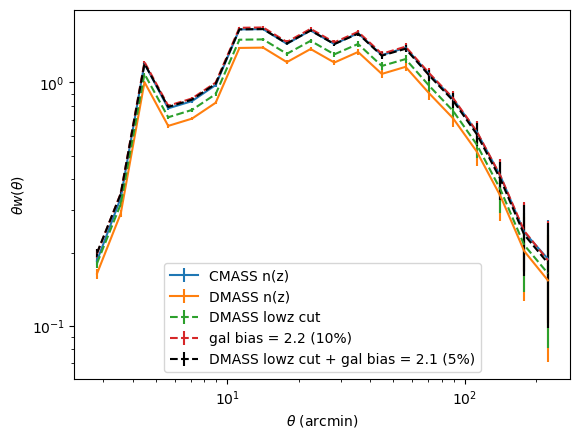

In [344]:
fig, ax = plt.subplots()
#ax.loglog(theta, wtheta_cmass, label='CMASS n(z)')
#ax.loglog(theta, wtheta_dmass, label='DMASS n(z)')

ax.errorbar( theta*1.0, theta*wtheta_cmass, yerr=theta*err, label='CMASS n(z)')
#ax.errorbar( theta*1.0, theta*wtheta_cmass_evol, yerr=theta*err, label='CMASS n(z), bias evolution')
#ax.errorbar( theta*0.98, wtheta_cmass_shifted, yerr=err, label='CMASS n(z) shifted')
ax.errorbar( theta*1.0, theta*wtheta_dmass, yerr=theta*err, label='DMASS n(z)')
#ax.errorbar( theta*1.0, theta*wtheta_dmass_evol, yerr=theta*err, label='DMASS n(z), bias evolution')
#ax.errorbar( theta*1.0, theta*wtheta_dmass2, yerr=theta*err, label='DMASS height increased n(z)', ls='--')
ax.errorbar( theta*1.0, theta*wtheta_dmass3, yerr=theta*err, label='DMASS lowz cut', ls='--')
ax.errorbar( theta*1.0, theta*wtheta_dmass4, yerr=theta*err, label='gal bias = 2.2 (10%)', ls='--')
ax.errorbar( theta*1.0, theta*wtheta_dmass5, yerr=theta*err, label='DMASS lowz cut + gal bias = 2.1 (5%)', ls='--', color = 'black')
#ax.axhspan(xmin=2.5, xmax=250, color='grey', alpha=0.1)
ax.legend()
ax.set_xlabel('$\\theta$ (arcmin)')
ax.set_ylabel('$\\theta w(\\theta)$')
ax.set_yscale('log')
ax.set_xscale('log')